In [53]:
import numpy as np
from functools import reduce
from math import ceil
from PIL import Image
import time
from scipy.linalg import toeplitz

np.set_printoptions(threshold=sys.maxsize)


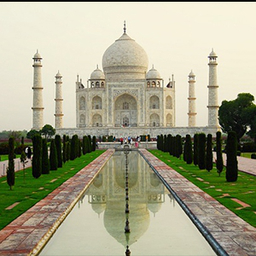

In [9]:
image = Image.open("tajmahal.jpg")
imagedata = np.asarray(image)

Image.fromarray(imagedata)

In [10]:
sharpen = [
    [0,0,0,0,0],
    [0,0,-1,0,0],
    [0,-1,5,-1,0],
    [0,0,-1,0,0],
    [0,0,0,0,0],
]
blur = [
    [0,0,0,0,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0],
]
edge_enhance = [
    [0,0,0],
    [-1,1,0],
    [0,0,0],
]
edge_detect = [
    [0,1,0],
    [1,-4,1],
    [0,1,0]
]
emboss = [
    [-2,-1,0],
    [-1,1,1],
    [0,1,2]
]
def torgbfilter(ker: np.ndarray) -> np.ndarray:
    """
    kernel of shape (n,n) to kernel of shape (n,n,3,3)
    """
    ker = np.asarray(ker)
    n = ker.shape[0]
    zero = np.zeros_like(ker)
    kerR = np.stack([ker,zero,zero],axis=-1)
    kerG = np.stack([zero,ker,zero],axis=-1)
    kerB = np.stack([zero,zero,ker],axis=-1)
    return np.stack([kerR,kerG,kerB],axis=-1)

def tobwfilter(ker: np.ndarray) -> np.ndarray:
    """
    kernel of shape (n,n,3,3) to kernel of shape (n,n,1,1)  
    """
    n = ker.shape[0]
    return ker[:,:,1,1].reshape((n,n,1,1))

sharpen = torgbfilter(sharpen)
blur = torgbfilter(blur)
edge_enhance = torgbfilter(edge_enhance)
edge_detect = torgbfilter(edge_detect)
emboss = torgbfilter(emboss)

# Sliding window

In [11]:

def point_conv(x: int,y:int,inp: np.ndarray,kernel: np.ndarray) -> float:
    """
    for a single channel input and kernel,
    returns the value of a (zero-padded) convolution (input*kernel) at x,y
    """

    d = kernel.shape[0]//2
    return sum(inp[x + loc[0]][y + loc[1]] * kernel[d + loc[0]][d + loc[1]] for loc in filter(
            lambda loc: x + loc[0] in range(inp.shape[0]) and y + loc[1] in range(inp.shape[1]),
            ((dx,dy) for dx in range(-d,d + 1) for dy in range(-d,d + 1))
        ))

def channel_conv(inp: np.ndarray, kernel: np.ndarray,stride: np.array) -> np.ndarray:
    """
    performs a convolution on a single channel
    kernel is assumed to be of rank 2
    input is asuumed to be of rank 2
    """

    d = kernel.shape[0]//2
    xstride = stride[0]
    ystride = stride[1]
    outwidth = ceil(inp.shape[0] - 2*d / stride[0])
    outheight = ceil(inp.shape[1] - 2*d / stride[1])
    out = np.empty((outwidth,outheight))
    for dx in range(outwidth):
        for dy in range(outheight):
            out[dx,dy] =  point_conv(d + dx * xstride,d + dy * ystride, inp, kernel)
    return out

def multi_conv(inp: np.ndarray, kernel: np.ndarray,stride: np.array) -> np.ndarray:
    """
    performs a convolution on multiple channels
    kernel is assumed to be of rank 3 (n,n,channel)
    input is assumed to be of rank 3 (width,height,channel)
    kernel and input are assumed to have the same amount of channels
    """

    return reduce(
        lambda c1,c2: c1 + c2,
        (channel_conv(inp[:,:,channel],kernel[:,:,channel],stride) for channel in range(kernel.shape[2]))
        )
        

def conv(inp: np.ndarray, kernels: np.ndarray, stride: np.array = [1,1],divisor: float =1) -> np.ndarray:
    """
    input is assumed to be of shape (width, height, channel)
    kernel is assumed to be of shape (n,n channel,filter) where n is not even
    stride is assumed to be [x_stride, y_stride]
    output is of shape(width,height,filter)
    """
    return np.stack([multi_conv(inp,kernels[:,:,:,filteridx],stride) for filteridx in range(kernels.shape[3])],
        axis=-1)/divisor


In [12]:
def imageconv(image,ker):
    divisor = ker.shape[0] ** 2 
    return conv(image,ker,[1,1],divisor).astype(np.uint8)


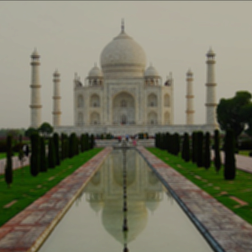

In [13]:
data = imageconv(imagedata,blur)
Image.fromarray(2*data).

In [14]:
noop = torgbfilter([[1]])
dd = imageconv(imagedata,noop)
(dd==imagedata).all()

True

In [23]:
image = Image.open("tajmahal.jpg").convert('L')
imagedata = np.asarray(image)

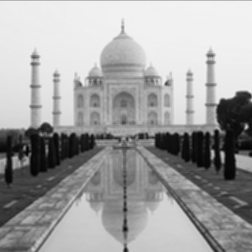

In [41]:
data = conv(imagedata.reshape((256,256,1)),tobwfilter(blur),[1,1],divisor=9).astype(np.uint8)[:,:,0]
Image.fromarray(data).convert('L')

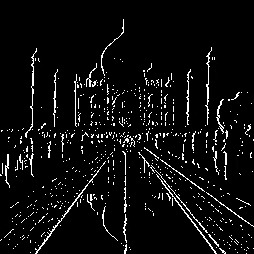

In [43]:
data = conv(imagedata.reshape((256,256,1)),tobwfilter(edge_enhance),[1,1],divisor=25).astype(np.uint8)[:,:,0]
Image.fromarray(data).convert('L')

 This doesn't really want to perfectly work for RGB, as i can't seem to understand GIMP specifications. Convolutions are working correctly up to the divisor's value.
 For greyscale images everything seems to be working correctly and the divisor's value is simply the filter's size squared.
 Examples which i'm trying to reproduce can be found on https://docs.gimp.org/2.6/en/plug-in-convmatrix.html

In [48]:
def block_toeplitz_mul(smalltoeps,mul):
    """
    sparse block matrix multiplication 
    this would be much faster in C
    still - around 10000x faster than the naive approach (which did not finish on my computer - OOM)
    """
    smalltoeps = [np.asarray(s) for s in smalltoeps]
    matrices = len(smalltoeps)
    outvech = smalltoeps[0].shape[0]
    out = np.zeros(outvech)
    maxwidth = mul.shape[0]
    ignored = set([i for i in range(matrices) if (smalltoeps[i] == 0).all()])
    for row in range(matrices):
        s = np.zeros(outvech)
        for column in range(min(row + 1,maxwidth)):
            toepidx = row - column
            if(toepidx in ignored):
                continue
            s = s + np.matmul(smalltoeps[toepidx],mul[column])
        out = np.vstack([out,s]) 
    return out[1:]

In [49]:
def single_mulconv(inp: np.ndarray, kernel:np.ndarray) -> np.ndarray:
    """
    performs convolution usinga single filter
    input and kernel are assumed to be of rank 2, returns rank 2 array
    """
    ksize = kernel.shape[0]
    inh = inp.shape[0]
    inw = inp.shape[1]
    outw = inw + ksize -1
    outh = inh + ksize -1

    kerpad = np.pad(kernel,[[outh-ksize,0],[0,outw - ksize]])
    smalltoeps = [toeplitz(kerpad[row],np.pad(np.asarray([kerpad[row][0]]),[0,inw - 1])) for row in reversed(range(kerpad.shape[0]))]
    zero = np.zeros_like(smalltoeps[0])
    return np.flipud( block_toeplitz_mul(smalltoeps,np.flipud(inp)))

def mulconv(inp: np.ndarray, filters: np.ndarray) -> np.ndarray:
    """
    multi filter convolution
    filters is assumed to have shape (n,n,filters)
    inp is assumed to be a rank 2 array
    """
    return np.vstack([single_mulconv(inp,filters[filterindex]) for filterindex in range(filters.shape[2])],axis=-1)

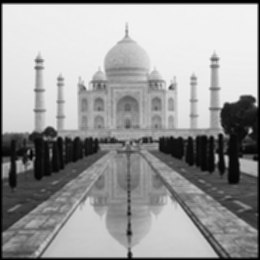

In [50]:
blurred = single_mulconv(imagedata,blur[:,:,0,0])
Image.fromarray(blurred/9).convert('L')

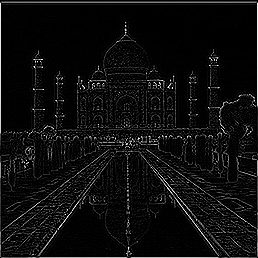

In [51]:
data = single_mulconv(imagedata,edge_detect[:,:,0,0])
Image.fromarray(data).convert('L')

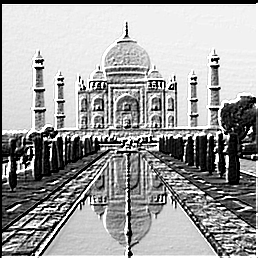

In [52]:
data = single_mulconv(imagedata,emboss[:,:,0,0])
Image.fromarray(data).convert('L')

Working as expected

# Time comparison

In [59]:
mulfilter = edge_enhance[:,:,0,0]
mulstart = time.time()
_ = single_mulconv(imagedata,mulfilter)
mulend = time.time()
inp = imagedata.reshape((256,256,1))
filters = tobwfilter(edge_enhance)
pystart = time.time()
_ = conv(inp,filters)
pyend = time.time()
print(f"Python sliding window - {pyend-pystart} seconds, Matrix multiplication {(mulend - mulstart )* 1000} milliseconds")

Python sliding window - 2.5903961658477783 seconds, Matrix multiplication 69.99468803405762 milliseconds


As expected - the matrix multiplication is much, much faster. A lot of that can be attributed to python loops being extremely slow compared to numpy matrix multiplication (and my python interpreter having no threading), but algorithmically the matrix method is still much faster, as a lot of calculations involving zeroes are simply skipped. My matrix algorithm implementation could be much faster still - the block Toeplitz multiplication is not vectorized at all, and I'm probably not using some property of Toeplitz matrices that could speed up multiplication.

Realistically, most heavy convolution calculations will be performed on a GPU, which thrives on paralellization. Since the matrix algorithm paralellizes much more easily, it's a much better choice for real calculations. 